## Setup and Configuration

In [ ]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt

from utils import (
    save_all_metadata, parse_output_types, get_optimal_resize_width,
    enumerate_snv_variants, name_filter, filter_by_strand,
    diff_mean, build_base_mask, collapse_ism, plot_all_outputs, find_exon_sequence
)
from alphagenome.models import dna_client
from alphagenome.data import gene_annotation, transcript as transcript_utils
from alphagenome.visualization import plot_components

# Load configuration
with open('config/PCCA.json', 'r', encoding='utf-8') as f:
    cfg = json.load(f)

cfg['results_dir'] = cfg['results_dir'] + '/ISM'
# Create directories
Path(cfg['data_dir']).mkdir(parents=True, exist_ok=True)
Path(cfg['results_dir']).mkdir(parents=True, exist_ok=True)
Path(f"{cfg['results_dir']}/{cfg['gene_symbol'].lower()}").mkdir(parents=True, exist_ok=True)

# Initialize model and load annotations
model = dna_client.create(cfg['dna_api_key'])
gtf = pd.read_feather(cfg['gtf_url'])
gene_interval = gene_annotation.get_gene_interval(gtf, gene_symbol=cfg['gene_symbol'])

# Determine optimal resize width
config_resize = cfg.get('resize_width')
optimal_resize = get_optimal_resize_width(gene_interval.width, config_resize)
interval = gene_interval.resize(optimal_resize)

print(f'Gene: {cfg["gene_symbol"]}')
print(f'Gene interval: {gene_interval.width:,} bp')
print(f'Resize width: {optimal_resize:,} bp ({optimal_resize // 1024}KB)')
if config_resize:
    print(f'  (from config)')
else:
    print(f'  (auto-selected)')

# Parse requested output types
requested_outputs = parse_output_types(cfg.get('requested_outputs', ['RNA_SEQ', 'SPLICE_SITE_USAGE']))
print(f'\nRequested output types: {[ot.name for ot in requested_outputs]}')

# Extract transcripts
transcripts_df = gene_annotation.filter_to_mane_select_transcript(gene_annotation.filter_protein_coding(gtf))
transcripts = transcript_utils.TranscriptExtractor(transcripts_df).extract(
    gene_annotation.get_gene_interval(gtf, gene_symbol=cfg['gene_symbol'])
)

# Load reference sequence once
ref_seq = str(SeqIO.to_dict(SeqIO.parse(cfg['fasta_path'], 'fasta'))[interval.chromosome].seq[interval.start:interval.end])

# Handle exon specification: either by index (int) or sequence (str)
if 'exon_sequence' in cfg:
    exon_start_rel, exon_end_rel = find_exon_sequence(ref_seq, cfg['exon_sequence'])
    exon_start = interval.start + exon_start_rel
    exon_end = interval.start + exon_end_rel
    print(f'Target exon (from sequence): {exon_start}-{exon_end}')
else:
    exon = transcripts[0].exons[cfg['exon_index']]
    exon_start = exon.start
    exon_end = exon.end
    print(f'Target exon {cfg["exon_index"]}: {exon_start}-{exon_end}')

# Check and adjust flank if needed
exon_length = exon_end - exon_start
min_flank = exon_length + 100
if cfg['flank'] < min_flank:
    print(f'Warning: flank ({cfg["flank"]}) < exon length + 100 ({min_flank}). Adjusting flank to {min_flank}.')
    cfg['flank'] = min_flank


Gene: OPA1
Gene interval: 104,668 bp
Resize width: 131,072 bp (128KB)
  (auto-selected)

Requested output types: ['RNA_SEQ', 'SPLICE_SITE_USAGE']
Target exon (from sequence): 193628508-193628616


## Step 1: Interval Prediction and Visualization

In [5]:
# Run interval prediction
ref_output = model.predict_interval(
    interval=interval,
    requested_outputs=requested_outputs,
    ontology_terms=cfg['ontology_terms'],
)

# Save metadata
save_all_metadata(ref_output, cfg['results_dir'], cfg['gene_symbol'])

# Display summary
print(f'Prediction complete for {len(requested_outputs)} output types:')
for output_type in requested_outputs:
    track_data = ref_output.get(output_type)
    if track_data is not None and hasattr(track_data, 'values'):
        print(f'  {output_type.name}: {track_data.values.shape} - {len(track_data.names)} tracks')

Saved RNA_SEQ metadata: results/ISM/ism/opa1/rna_seq_metadata.csv
Saved SPLICE_SITE_USAGE metadata: results/ISM/ism/opa1/splice_site_usage_metadata.csv
Prediction complete for 2 output types:
  RNA_SEQ: (131072, 17) - 17 tracks
  SPLICE_SITE_USAGE: (131072, 18) - 18 tracks


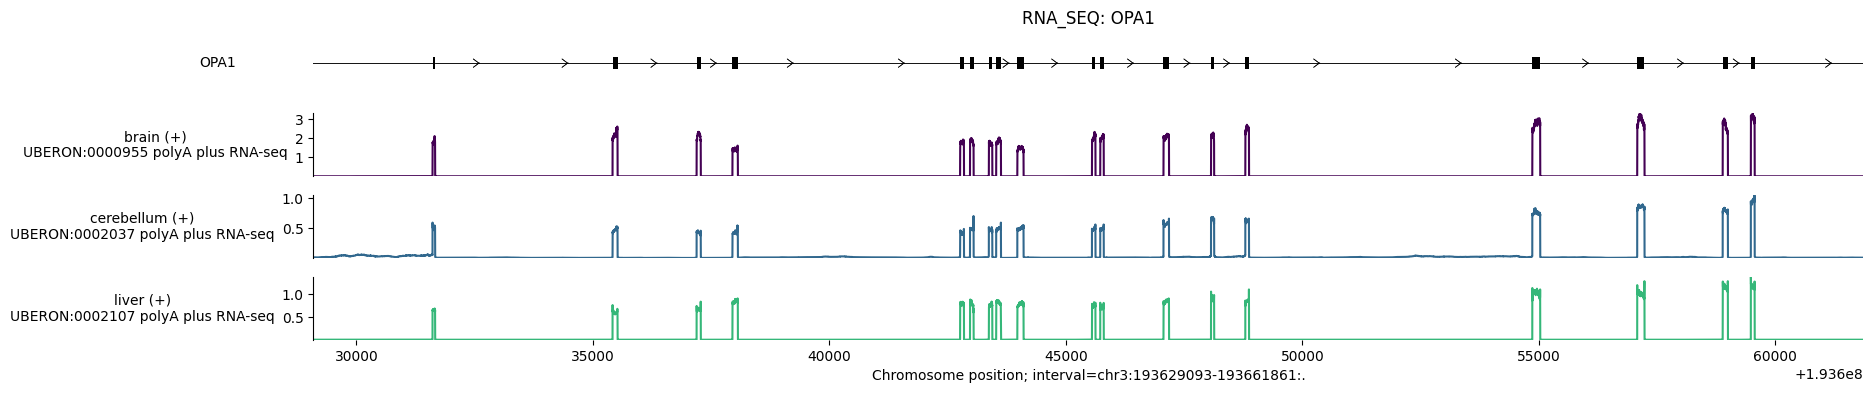

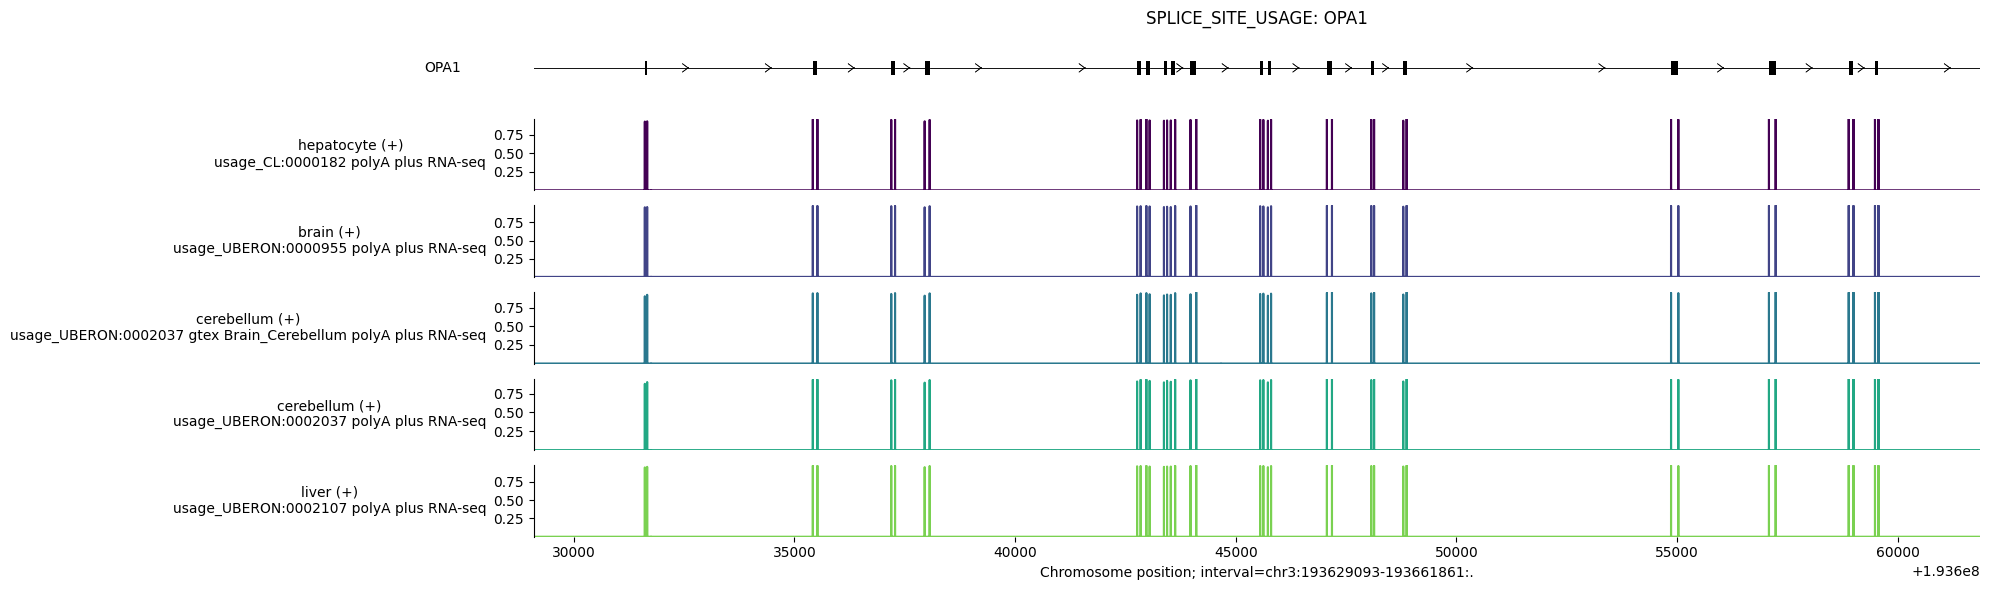

In [6]:
# Visualize predictions
viz_width = cfg.get('viz_resize_width', 2**15)
plot_all_outputs(ref_output, transcripts, requested_outputs, cfg, resize_width=viz_width)

## Step 2: Variant Enumeration and Prediction

In [7]:
# Define variant window
from alphagenome.data.genome import Interval

variant_interval = Interval(
    chromosome=interval.chromosome,
    start=exon_start,
    end=exon_end,
).resize(cfg['flank'])

if cfg['flank'] > 1000:
    print(f'Warning: Using flank of {cfg["flank"]} bp around exon, which may lead to high memory usage.')

# Enumerate single-nucleotide variants
start_rel = variant_interval.start - interval.start
end_rel = variant_interval.end - interval.start
variants = enumerate_snv_variants(ref_seq, start_rel, end_rel)
print(f'Enumerated {len(variants)} variants in window: {variant_interval.start}-{variant_interval.end}')


Enumerated 3000 variants in window: 193628062-193629062


In [8]:
# Run variant predictions
outputs = model.predict_sequences(
    intervals=[interval] * len(variants),
    sequences=variants,
    requested_outputs=requested_outputs,
    ontology_terms=cfg['ontology_terms']
)

print(f'Variant predictions complete: {len(outputs)} sequences')

100%|██████████| 3000/3000 [10:06<00:00,  4.95it/s]

Variant predictions complete: 3000 sequences


In [9]:
# Process and save variant predictions
track_pattern = cfg.get('track_filter', '')

for output_type in requested_outputs:
    concatenated_data = []
    for i in range(len(outputs)):
        track_data = outputs[i].get(output_type)
        
        # Apply track filtering
        if track_pattern and hasattr(track_data, 'filter_tracks'):
            track_data = track_data.filter_tracks(name_filter(track_data.names, track_pattern))
        
        # Apply strand filtering
        if 'strand' in cfg:
            track_data = filter_by_strand(track_data, cfg['strand'])
        
        concatenated_data.append(track_data.values.mean(axis=1))
    
    if concatenated_data:
        result = np.stack(concatenated_data, axis=1)
        result = result.reshape(result.shape[0], -1, 3)
        filename = f"{cfg['results_dir']}/{cfg['gene_symbol'].lower()}/{output_type.name.lower()}_variants.npy"
        np.save(filename, result)
        print(f'Saved {output_type.name} predictions: {filename} (shape: {result.shape})')

Saved RNA_SEQ predictions: results/ISM/ism/opa1/rna_seq_variants.npy (shape: (131072, 1000, 3))
Saved SPLICE_SITE_USAGE predictions: results/ISM/ism/opa1/splice_site_usage_variants.npy (shape: (131072, 1000, 3))


## Step 3: ISM Scoring and Sequence Logo

Loaded RNA_SEQ variant array: (131072, 1000, 3) -> results/ISM/ism/opa1/rna_seq_variants.npy
RNA_SEQ collapsed ISM shape: (1000, 4)
Loaded SPLICE_SITE_USAGE variant array: (131072, 1000, 3) -> results/ISM/ism/opa1/splice_site_usage_variants.npy
SPLICE_SITE_USAGE collapsed ISM shape: (1000, 4)


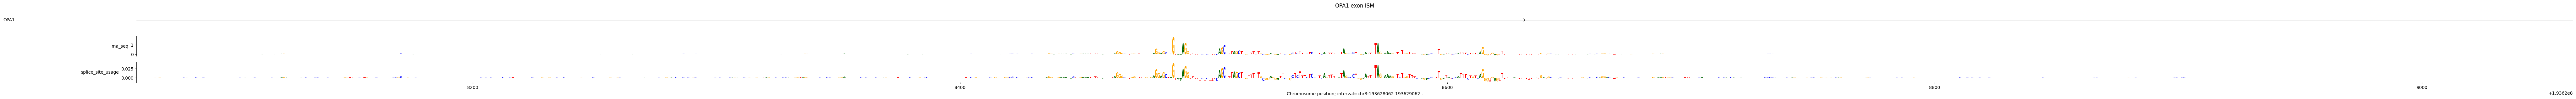

In [10]:
# Prepare for ISM scoring
start = exon_start - interval.start
end = exon_end - interval.start

# Reference subsequence for logo masking
ref_subseq = str(SeqIO.to_dict(SeqIO.parse(cfg['fasta_path'], 'fasta'))[interval.chromosome].seq[variant_interval.start:variant_interval.end])
mask = build_base_mask(ref_subseq)

plots = []
for output_type in requested_outputs:
    # Load variant prediction array
    variant_path = f"{cfg['results_dir']}/{cfg['gene_symbol'].lower()}/{output_type.name.lower()}_variants.npy"
    try:
        variant_array = np.load(variant_path)
    except FileNotFoundError:
        print(f"Skipping {output_type.name}: variants file not found -> {variant_path}")
        continue

    print(f"Loaded {output_type.name} variant array: {variant_array.shape} -> {variant_path}")

    # Get corresponding reference tracks
    track_data = ref_output.get(output_type)
    if track_data is None:
        print(f"Skipping {output_type.name}: missing in reference output")
        continue

    # Track filtering
    if cfg.get('track_filter'):
        track_data = track_data.filter_tracks(name_filter(track_data.names, cfg['track_filter']))
    if 'strand' in cfg:
        track_data = filter_by_strand(track_data, cfg['strand'])

    ref_values = track_data.values

    # Compute ISM scores
    ism_scores = diff_mean(ref_values, variant_array, start, end)
    collapsed = collapse_ism(ism_scores, mask)
    print(f"{output_type.name} collapsed ISM shape: {collapsed.shape}")

    ylabel = f"{output_type.name.lower()}"
    plots.append(plot_components.SeqLogo(scores=collapsed, scores_interval=variant_interval, ylabel=ylabel, max_width=cfg['flank']))

# Plot sequence logos with transcript annotation
components = [plot_components.TranscriptAnnotation(transcripts)] + plots

plot_components.plot(
    components,
    interval=variant_interval,
    fig_width=variant_interval.width // 10,
    title=f"{cfg['gene_symbol']} exon ISM"
)
plt.show()
